# GdLS Neutrons
Running macro: `gdls_neutrons`

Key points
```
/gps/particle neutron
/gps/ene/type Gauss
/gps/ene/mono 0.06 eV
/gps/ene/sigma 0.003 eV
/gps/pos/type Volume
/gps/pos/shape Cylinder
/gps/pos/centre 0 0 1465 mm
/gps/pos/inner_radius 0 mm
/gps/pos/radius 40000 mm
/gps/pos/halfz 40000 mm
/gps/pos/confine ScintillatorCenter
/gps/ang/type iso
```

In [1]:
import baccarat_verbose_analysis as bv 
import multiprocessing as mp
import tqdm
import functools
import numpy as np
import uproot as up

In [2]:
baccarat_version = '6.2.11'
der_version = '9.1.0'
lzap_version = '5.2.8'

npy_base_path = "/hdfs/user/ak18773/od_simulations/BACCARAT_" + baccarat_version + "_DER_" + der_version + "_LZAP_" + lzap_version + "/gdls_neutrons/baccarat_verbose"

In [4]:
all_neutron_dicts = bv.particle_loader.get_particle_dictionaries(npy_base_path, n_cores=20, 
                                                                 particle='neutron', 
                                                                 merge_multiples=True, add_filename=True, 
                                                                 max_n_files=None) 

Base path /hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/gdls_neutrons/baccarat_verbose
Found 35948 npy files
Processing 35948 npy files


35948it [38:48, 15.44it/s]

Processing complete
N. neutron extracted: 35948


In [6]:
np.save("data/all_neutron_dicts.npy", all_neutron_dicts)

In [3]:
all_neutron_dicts = np.load("data/all_neutron_dicts.npy", allow_pickle=True)
print('Loaded {0} neutrons'.format(len(all_neutron_dicts)))

Loaded 35948 neutrons


In [7]:
# Basic neutron info

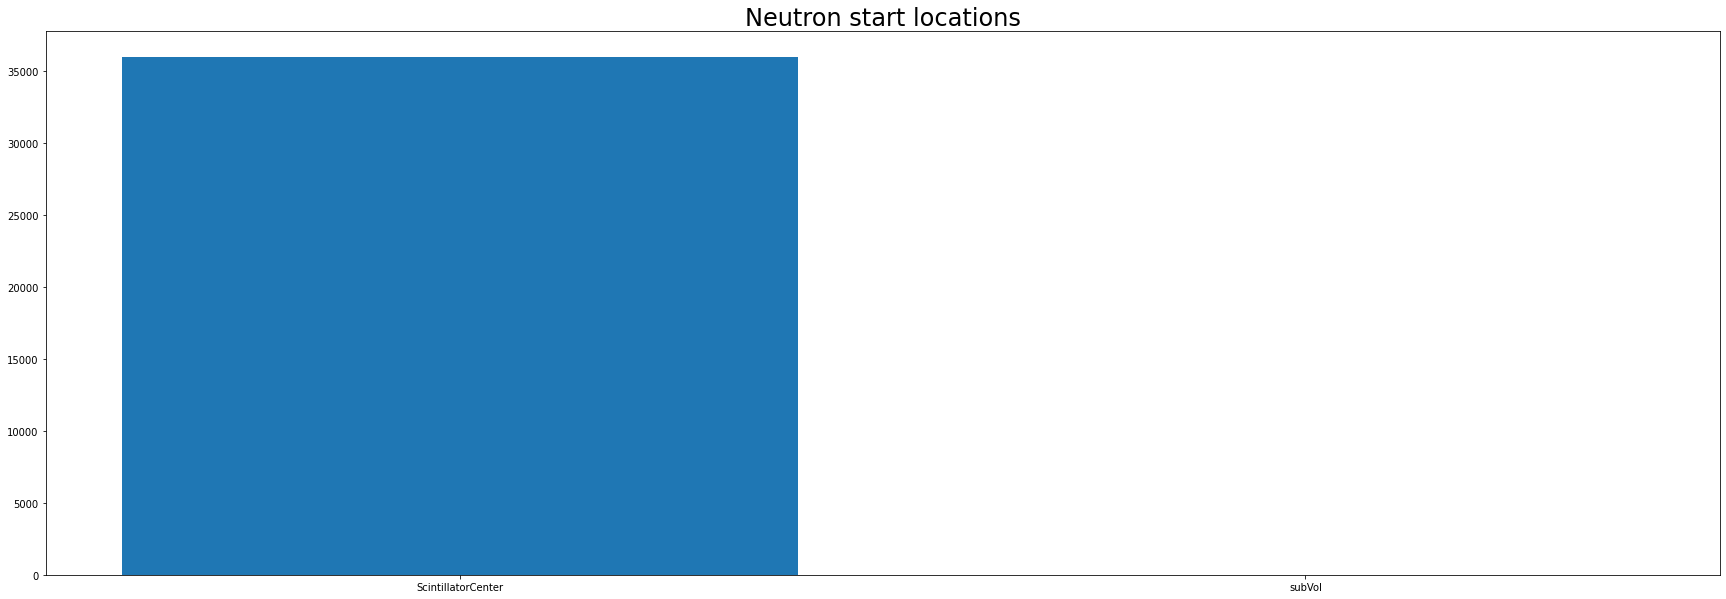

In [10]:
locations = [neutron['NextVolume'][0] for neutron in all_neutron_dicts]
weights, bins, _, _ = bv.particle_info.create_histogram(np.unique(locations), locations, minimum_count=0)
bv.particle_info.plot_bar(bins,weights, title='Neutron start locations')

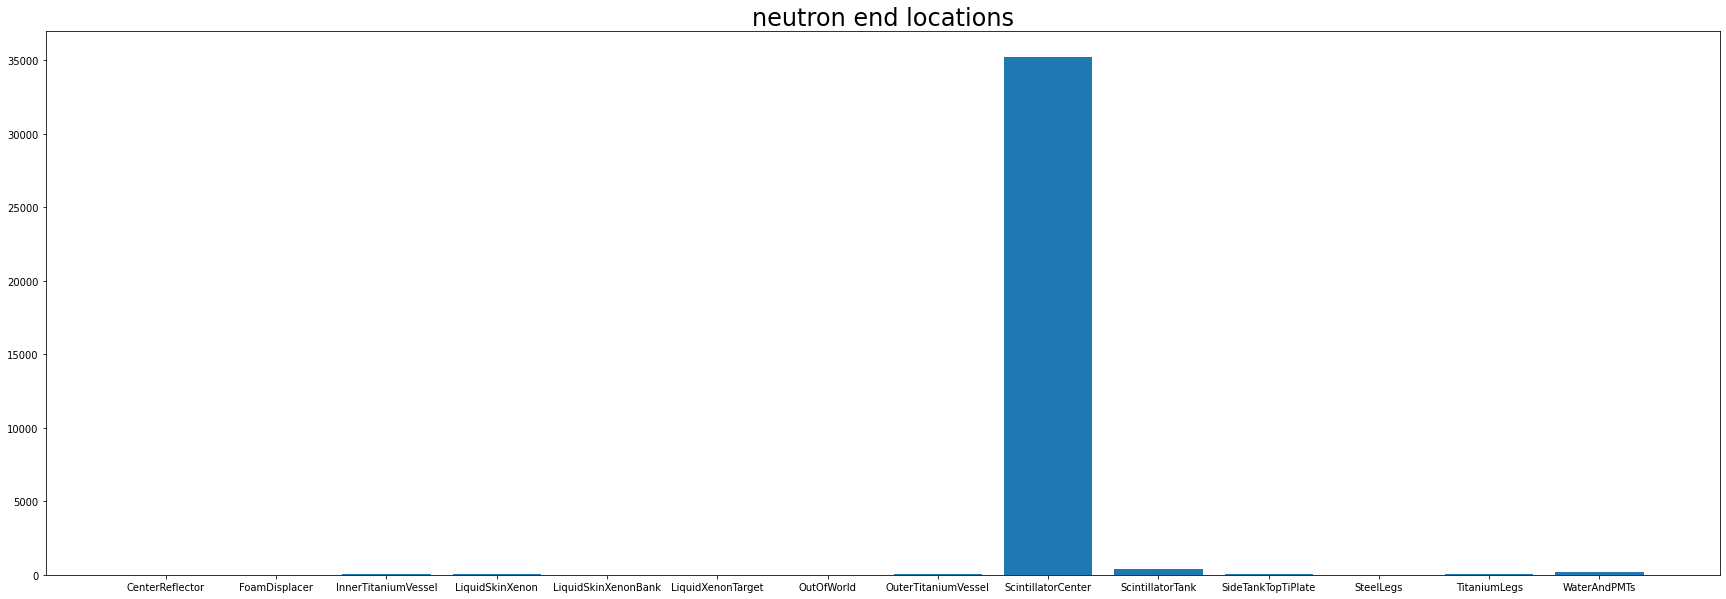

In [13]:
locations = [neutron['NextVolume'][-1] for neutron in all_neutron_dicts]
weights, bins, _, _ = bv.particle_info.create_histogram(np.unique(locations), locations, minimum_count=1)
bv.particle_info.plot_bar(bins,weights, title='neutron end locations')

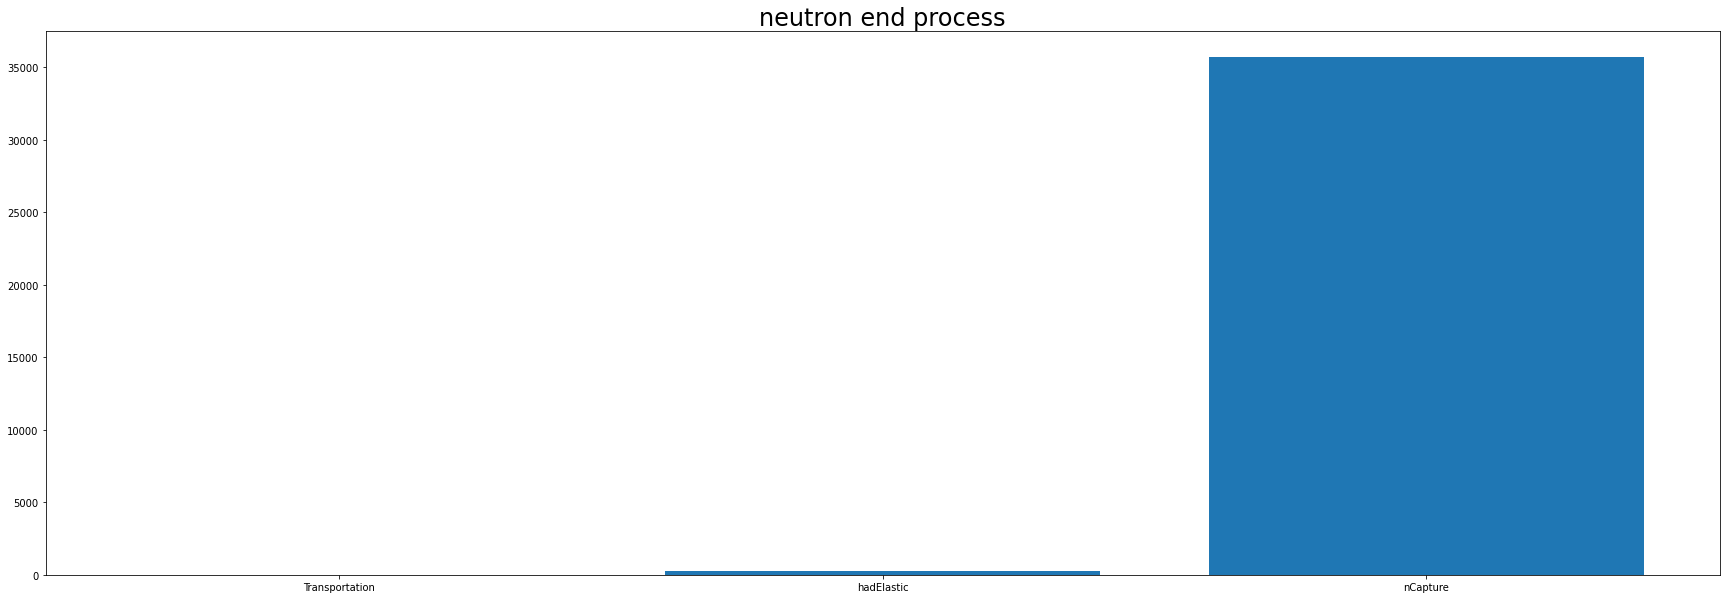

In [14]:
end_process = [neutron['ProcName'][-1] for neutron in all_neutron_dicts]
weights, bins, _, _ = bv.particle_info.create_histogram(np.unique(end_process), end_process)
bv.particle_info.plot_bar(bins,weights, title='neutron end process')

In [5]:
with mp.Pool(30) as pool:
    result = list(tqdm.tqdm(pool.imap(bv.secondaries.get_neutron_capture_particle,all_neutron_dicts)))     

35948it [38:30, 15.56it/s]


In [6]:
captures = [r[2] for r in result]

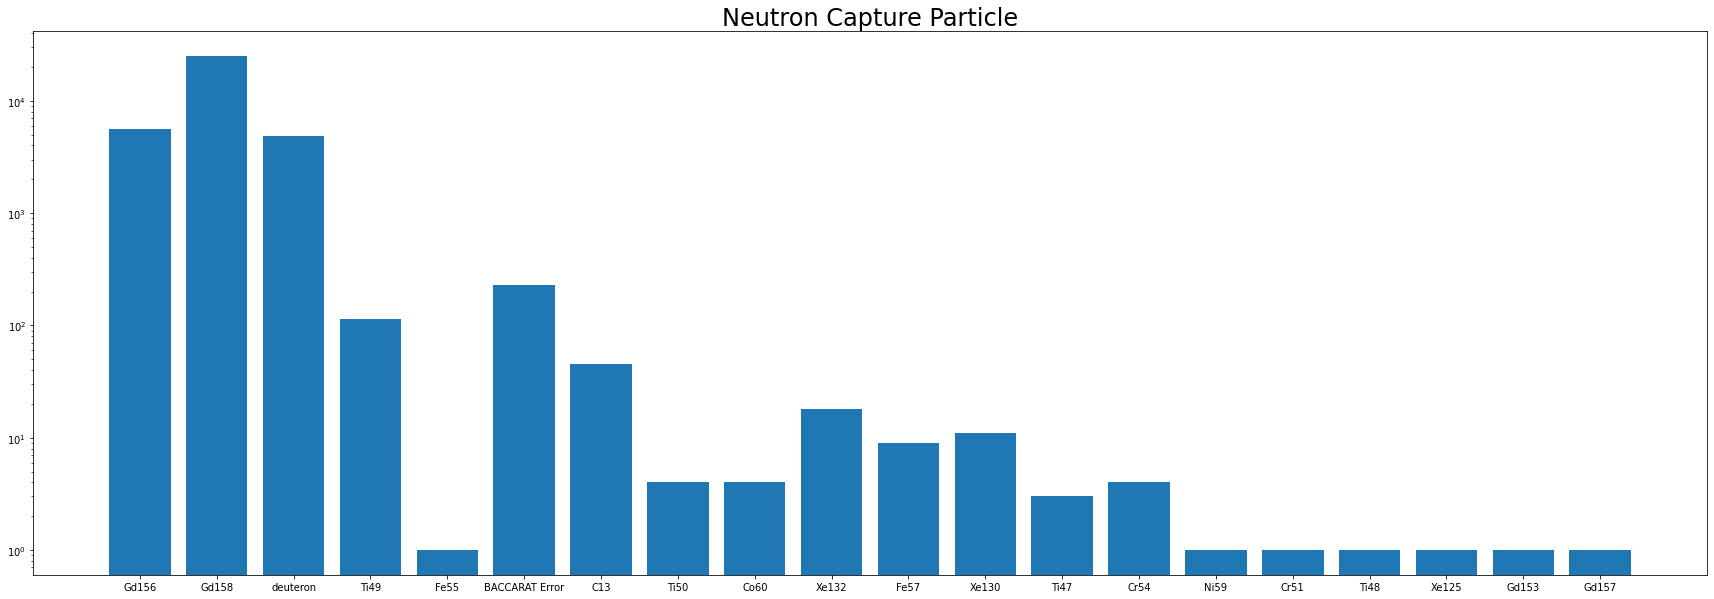

In [7]:
unique_captures = []
for c in captures:
    in_unique = False
    for j in unique_captures:
        if c == j:
            in_unique = True
    if not in_unique:
        unique_captures.append(c)
        
weights, bins, _, _ = bv.particle_info.create_histogram(unique_captures, captures)
new_bins = []
for b in bins:
    if b is not None:
        new_bins.append(b)
    else:
        new_bins.append('BACCARAT Error')
bv.particle_info.plot_bar(new_bins,weights, title='Neutron Capture Particle', logy=True)

In [19]:
with mp.Pool(30) as pool:
    result = list(tqdm.tqdm(pool.imap(functools.partial(bv.secondaries.get_neutron_captures,which_particles_to_keep=['Gd158', 'Gd156']),all_neutron_dicts)))

35948it [36:58, 16.21it/s]


In [20]:
print('Number of Gd captures (inc None): {0}'.format(len(result)))
gd_capture_neutrons = [r for r in result if r is not None]
print('Number of Gd captures: {0}'.format(len(gd_capture_neutrons)))

Number of Gd captures (inc None): 35948
Number of Gd captures: 30660


In [21]:
np.save("data/gd_neutron_dicts.npy", gd_capture_neutrons)

In [5]:
gd_capture_neutrons = np.load("data/gd_neutron_dicts.npy", allow_pickle=True)
print('N neutrons loaded: {0}'.format(len(gd_capture_neutrons)))

N neutrons loaded: 30889


In [72]:
def get_seeds_and_event_ids(event_list):
    
    seed_event_dict = {}
    seeds = []
    
    for i in tqdm.tqdm(range(len(event_list))):
        event = event_list[i]
        fname = event['filename']
        seed = fname[fname.find('seed')+4:fname.find('_event')]
        event_id = fname[fname.rfind('event')+5:fname.rfind('.')]
        
        seeds.append(seed)
    
    seeds = np.unique(seeds).tolist()
    for s in seeds:
        seed_event_dict[s] = []

    for i in tqdm.tqdm(range(len(event_list))):
        event = event_list[i]
        fname = event['filename']
        seed = fname[fname.find('seed')+4:fname.find('_event')]
        event_id = fname[fname.rfind('event')+5:fname.rfind('.')]
        l = seed_event_dict[seed]
        l.append(event_id)
        seed_event_dict[seed] = l
            
    return seed_event_dict

In [73]:
gd_capture_seeds_and_ids = get_seeds_and_event_ids(gd_capture_neutrons)

100%|██████████| 30660/30660 [00:00<00:00, 624453.04it/s]


In [79]:
lzap_base_path = "/hdfs/user/ak18773/od_simulations/BACCARAT_" + baccarat_version + "_DER_" + der_version + "_LZAP_" + lzap_version + "/gdls_neutrons/lzap_output"

In [81]:
tfile = up.open(lzap_base_path + '/LZAP_SEED{0}.root'.format(100))

In [82]:
tfile.keys()

['RQMCTruth;3', 'RQMCTruth;2', 'Events;1', 'Scatters;1']

In [84]:
events = tfile['Events']

In [86]:
rawFileName = events['eventHeader.rawFileName'].array()

In [87]:
truth = tfile['RQMCTruth']

In [89]:
baccEvent = truth['mcTruthEvent.baccEvent'].array()

In [91]:
len(baccEvent)

98

In [112]:
working_seeds = []
with open('event_selection/gdls_rawfilenames.list', 'w') as f:
    lzap_base_path = "/hdfs/user/ak18773/od_simulations/BACCARAT_" + baccarat_version + "_DER_" + der_version + "_LZAP_" + lzap_version + "/gdls_neutrons/lzap_output"
    for i in tqdm.tqdm((gd_capture_seeds_and_ids.keys())):
        try:
            seed = i
            tfile = up.open(lzap_base_path + '/LZAP_SEED{0}.root'.format(seed))
            events = tfile['Events']
            rawFileName = events['eventHeader.rawFileName'].array()[0]
            f.write(str(rawFileName))
            f.write('\n')
            working_seeds.append(i)
        except:
            continue

100%|██████████| 486/486 [07:21<00:00,  1.10it/s]


In [114]:
print('N. Gd capture Root files: {0}'.format(len(gd_capture_seeds_and_ids.keys())))
print('N. Actual Root files: {0}'.format(len(working_seeds)))

N. Gd capture Root files: 486
N. Actual Root files: 464


In [120]:
with open('event_selection/gdls_baccarat_eventids.list', 'w') as f:
    for s in working_seeds:
        ids = gd_capture_seeds_and_ids[s]
        for i in ids:
            f.write(i)
            f.write(' ')
        f.write('\n')

In [122]:
print("BACCARAT_" + baccarat_version + "_DER_" + der_version + "_LZAP_" + lzap_version)

BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8


In [ ]:
# H-captures

In [8]:
with mp.Pool(30) as pool:
    result = list(tqdm.tqdm(pool.imap(functools.partial(bv.secondaries.get_neutron_captures,which_particles_to_keep=['deuteron']),all_neutron_dicts)))

35948it [37:58, 15.77it/s]


In [9]:
print('Number of H captures (inc None): {0}'.format(len(result)))
h_capture_neutrons = [r for r in result if r is not None]
print('Number of H captures: {0}'.format(len(h_capture_neutrons)))

Number of H captures (inc None): 35948
Number of H captures: 4838


In [10]:
np.save("data/h_neutron_dicts.npy", h_capture_neutrons)

In [11]:
def get_seeds_and_event_ids(event_list):
    
    seed_event_dict = {}
    seeds = []
    
    for i in tqdm.tqdm(range(len(event_list))):
        event = event_list[i]
        fname = event['filename']
        seed = fname[fname.find('seed')+4:fname.find('_event')]
        event_id = fname[fname.rfind('event')+5:fname.rfind('.')]
        
        seeds.append(seed)
    
    seeds = np.unique(seeds).tolist()
    for s in seeds:
        seed_event_dict[s] = []

    for i in tqdm.tqdm(range(len(event_list))):
        event = event_list[i]
        fname = event['filename']
        seed = fname[fname.find('seed')+4:fname.find('_event')]
        event_id = fname[fname.rfind('event')+5:fname.rfind('.')]
        l = seed_event_dict[seed]
        l.append(event_id)
        seed_event_dict[seed] = l
            
    return seed_event_dict

In [12]:
h_capture_seeds_and_ids = get_seeds_and_event_ids(h_capture_neutrons)

100%|██████████| 4838/4838 [00:00<00:00, 633433.52it/s]


In [13]:
lzap_base_path = "/hdfs/user/ak18773/od_simulations/BACCARAT_" + baccarat_version + "_DER_" + der_version + "_LZAP_" + lzap_version + "/gdls_neutrons/lzap_output"

In [14]:
working_seeds = []
with open('event_selection/h_capture_rawfilenames.list', 'w') as f:
    lzap_base_path = "/hdfs/user/ak18773/od_simulations/BACCARAT_" + baccarat_version + "_DER_" + der_version + "_LZAP_" + lzap_version + "/gdls_neutrons/lzap_output"
    for i in tqdm.tqdm((h_capture_seeds_and_ids.keys())):
        try:
            seed = i
            tfile = up.open(lzap_base_path + '/LZAP_SEED{0}.root'.format(seed))
            events = tfile['Events']
            rawFileName = events['eventHeader.rawFileName'].array()[0]
            f.write(str(rawFileName))
            f.write('\n')
            working_seeds.append(i)
        except:
            continue

100%|██████████| 461/461 [05:36<00:00,  1.37it/s]


In [15]:
print('N. H capture Root files: {0}'.format(len(h_capture_seeds_and_ids.keys())))
print('N. Actual Root files: {0}'.format(len(working_seeds)))

N. H capture Root files: 461
N. Actual Root files: 439


In [16]:
with open('event_selection/h_baccarat_eventids.list', 'w') as f:
    for s in working_seeds:
        ids = h_capture_seeds_and_ids[s]
        for i in ids:
            f.write(i)
            f.write(' ')
        f.write('\n')